# Employee Attrition Analysis — 06: Model Selection & Validation

***Comprehensive model comparison and champion selection with robust cross-validation***

**Author:** Katherine Ygbuhay  
**Updated:** 2025-01-04  
**Stage:** 06 — Model Selection & Validation  
**Runtime:** ~25 minutes  

## Objective

Compare performance across logistic regression baseline and tree-based models to identify the champion model for predicting employee attrition with robust cross-validation and business-appropriate recall thresholds.

## Scope & Approach

- **Model comparison** between logistic regression baseline and advanced tree-based approaches (Decision Tree, Random Forest, XGBoost)
- **Stratified cross-validation** for stable performance assessment across model families  
- **Visual diagnostics** including confusion matrices, ROC curves, and precision-recall curves
- **Champion selection** based on ROC-AUC with tie-breaking by F1 and recall metrics

## Key Outputs

- Champion model identification with performance justification
- Cross-validation stability assessment with confidence intervals
- Comprehensive visual diagnostics for model trade-off analysis
- Final validation summary report in `docs/modeling/validation_summary.md`

## Prerequisites

- Baseline logistic regression results from `04_baseline_logreg.ipynb`
- Tree-based model results from `05_tree_models.ipynb`
- Understanding of business recall requirements for attrition prediction

---

## 1. Imports & Setup

In [1]:
# Core stack
import os
import re
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project bootstrap (paths, theme, accessibility) and notes helper
from src.bootstrap import setup_notebook, write_notes

# Visualization defaults (font sizes, title casing helpers)
from src.viz_helpers import apply_plot_rc_defaults, pretty_label

# Modeling utilities
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

# Dataset artifact names
RAW_NAME  = "salifort_employee_attrition_raw.csv"
PROC_NAME = "salifort_employee_attrition_cleaned.csv"

# Pin the project to avoid resolving a sibling repo with a similar structure.
os.environ["PORTFOLIO_PROJECT"] = "employee_attrition_analysis"

# Initialize notebook (theme/seed/accessibility) and resolve project paths; load processed data
P, df = setup_notebook(
    raw_filename=RAW_NAME,
    proc_filename=PROC_NAME,
    load="proc",
    verbose=True,
)

# Apply plotting rc defaults (font sizes, readability)
apply_plot_rc_defaults()

# --- Utility: Parse metrics markdown into DataFrame ---
def parse_metrics_from_md(md_path):
    """Extract metrics table from a markdown results file into a DataFrame."""
    text = md_path.read_text()
    lines = [line for line in text.splitlines() if line.strip().startswith("|")]
    if not lines:
        return pd.DataFrame()
    rows = [line.strip("| ").split(" | ") for line in lines]
    header, data = rows[0], rows[2:]  # skip separator row
    return pd.DataFrame(data, columns=header).set_index("model")

# --- Load prior results ---
baseline_path = P.DOCS / "modeling" / "baseline_results.md"
tree_path     = P.DOCS / "modeling" / "tree_model_results.md"

print("Baseline:", baseline_path.exists(), "| Tree models:", tree_path.exists())

baseline_df = parse_metrics_from_md(baseline_path)
tree_df     = parse_metrics_from_md(tree_path)

# Ensure numeric types (future-proof: explicit conversion)
for df_ in [baseline_df, tree_df]:
    for col in df_.columns[1:]:  # skip 'model'
        try:
            df_[col] = pd.to_numeric(df_[col])
        except Exception:
            # If conversion fails, leave column as-is (likely categorical)
            pass

# --- Combine results ---
results_df = pd.concat([baseline_df, tree_df], axis=0)
print("📊 Combined results:\n", results_df)

# Candidate champion (by ROC-AUC → F1 → Recall)
sort_keys = ["roc_auc", "f1", "recall"]
champion = results_df.sort_values(sort_keys, ascending=False).index[0]
print(f"📌 Candidate champion across families: {champion}")

🎨 Accessibility defaults applied (colorblind palette, high-contrast, safe colormap).
✅ Accessibility defaults applied
📁 Project root → /home/admin/Documents/portfolio/coursework/google-advanced-data-analytics/employee_attrition_analysis
✅ Loaded PROC: data/processed/salifort_employee_attrition_cleaned.csv | shape=(14999, 11)
Baseline: True | Tree models: True
📊 Combined results:
                  accuracy  precision  recall      f1  roc_auc
model                                                        
XGBoost            0.9853     0.9827  0.9552  0.9688   0.9945
RandomForest       0.9767     0.9777  0.9230  0.9496   0.9907
DecisionTree        0.924     0.7819  0.9440  0.8553   0.9466
LogisticBaseline   0.7727     0.5143  0.8053  0.6277   0.8369
📌 Candidate champion across families: XGBoost


## 2. Reload Candidate Models & Metrics

In [2]:
# Reload results from previous steps
baseline_path = P.DOCS / "modeling" / "baseline_results.md"
tree_path     = P.DOCS / "modeling" / "tree_model_results.md"

print("Baseline:", baseline_path.exists(), "| Tree models:", tree_path.exists())

# Candidate champion from trees
champion_name = "XGBoost" if "XGBoost" in results_df.index else results_df.index[0]
print(f"📌 Candidate champion: {champion_name}")

Baseline: True | Tree models: True
📌 Candidate champion: XGBoost


## 3. Cross-Validation

In [3]:
## 3) Cross-Validation for Champion Model

from sklearn.linear_model import LogisticRegression

# --- Rebuild preprocessing pipeline ---
categorical = df.select_dtypes(include="object").columns.tolist()
numeric     = df.select_dtypes(include=np.number).drop(columns=["left"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ]
)

# --- Define candidate pipelines (must mirror earlier NBs) ---
models = {
    "LogisticBaseline": Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", LogisticRegression(
            solver="liblinear", class_weight="balanced", random_state=42
        )),
    ]),
    "DecisionTree": Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", DecisionTreeClassifier(
            max_depth=4, min_samples_leaf=20, random_state=42, class_weight="balanced"
        )),
    ]),
    "RandomForest": Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=300, max_depth=None, min_samples_leaf=10,
            n_jobs=-1, random_state=42, class_weight="balanced"
        )),
    ]),
}

# Optional XGBoost
if "XGBoost" in results_df.index:
    from xgboost import XGBClassifier
    models["XGBoost"] = Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", XGBClassifier(
            n_estimators=400, max_depth=6, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9,
            reg_lambda=1.0, reg_alpha=0.0,
            objective="binary:logistic", eval_metric="auc",
            random_state=42, n_jobs=-1
        )),
    ])

# --- Cross-validation on champion ---
X, y = df.drop(columns="left"), df["left"]
champion_pipe = models[champion]  # use the earlier-selected champion name

cv_auc = cross_val_score(champion_pipe, X, y, cv=5, scoring="roc_auc")
print(f"📊 Champion: {champion}")
print(f"CV ROC-AUC: {cv_auc.mean().round(4)} ± {cv_auc.std().round(4)}")

📊 Champion: XGBoost
CV ROC-AUC: 0.9943 ± 0.0059


## 4. Confusion Matrix (Champion)

ℹ️ Created train/val split for visuals.


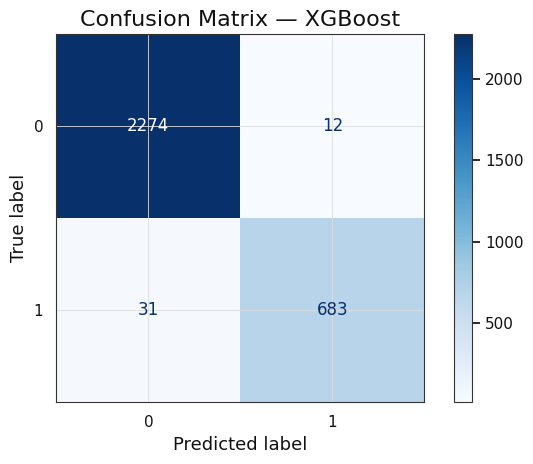

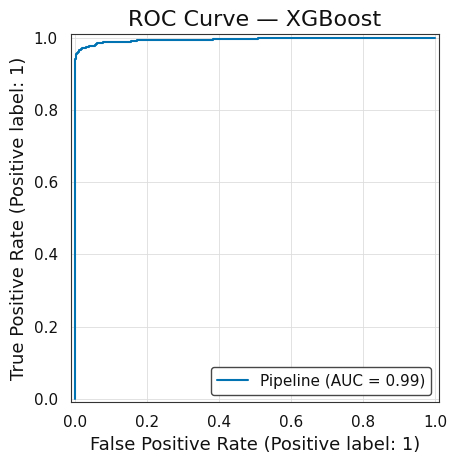

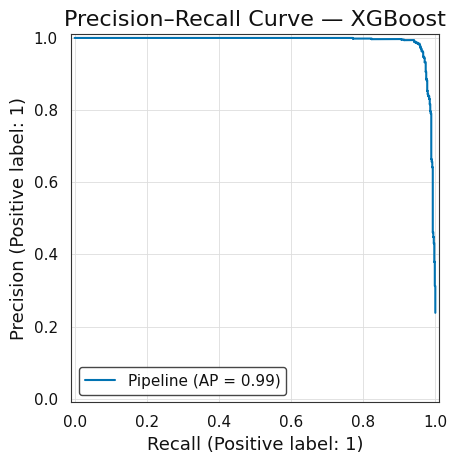

In [4]:
## 4) Confusion Matrix + ROC/PR Curves (Champion)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

# --- Ensure train/validation split exists ---
if "X_train" not in globals() or "X_val" not in globals():
    X = df.drop(columns="left")
    y = df["left"]
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )
    print("ℹ️ Created train/val split for visuals.")

# --- Utility: get continuous scores for ROC/PR ---
def _positive_scores(estimator, X_):
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X_)[:, 1]
    if hasattr(estimator, "decision_function"):
        return estimator.decision_function(X_)
    # fallback: not ideal for AUC, but keeps code robust
    return estimator.predict(X_).astype(float)

# --- Fit champion on training data ---
champion_pipe = models[champion]
champion_pipe.fit(X_train, y_train)

# --- Confusion Matrix (validation) ---
disp_cm = ConfusionMatrixDisplay.from_estimator(
    champion_pipe, X_val, y_val, cmap="Blues", normalize=None
)
plt.title(f"Confusion Matrix — {champion}")
plt.tight_layout()
plt.show()

# --- ROC Curve (validation) ---
RocCurveDisplay.from_estimator(champion_pipe, X_val, y_val)
plt.title(f"ROC Curve — {champion}")
plt.tight_layout()
plt.show()

# --- Precision–Recall Curve (validation) ---
PrecisionRecallDisplay.from_estimator(champion_pipe, X_val, y_val)
plt.title(f"Precision–Recall Curve — {champion}")
plt.tight_layout()
plt.show()


## 5. Save Notes & Assessment Check

In [5]:
# --- Ensure we have a fitted champion and a val split (defensive) ---
if "X_train" not in globals() or "X_val" not in globals():
    X = df.drop(columns="left")
    y = df["left"]
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )
    print("ℹ️ Created train/val split for metrics.")

# Fit champion if needed (no-op if already fit in §4)
try:
    _ = champion_pipe.predict(X_val)
except Exception:
    champion_pipe.fit(X_train, y_train)

def get_positive_scores(estimator, X):
    """Continuous score for ROC/PR: proba[:,1] → decision_function → predict."""
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        return estimator.decision_function(X)
    return estimator.predict(X).astype(float)

# --- Validation metrics (held-out set) ---
y_val_pred  = champion_pipe.predict(X_val)
y_val_score = get_positive_scores(champion_pipe, X_val)

val_acc  = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred, zero_division=0)
val_rec  = recall_score(y_val, y_val_pred)
val_f1   = f1_score(y_val, y_val_pred)
val_auc  = roc_auc_score(y_val, y_val_score) if y_val_score is not None else np.nan

# --- Cross-validation (optional; uses full df if available) ---
cv_mean = cv_std = None
try:
    # If X,y not in scope yet, define once
    if "X" not in globals() or "y" not in globals():
        X, y = df.drop(columns="left"), df["left"]
    cv_scores = cross_val_score(champion_pipe, X, y, cv=5, scoring="roc_auc")
    cv_mean, cv_std = float(np.mean(cv_scores)), float(np.std(cv_scores))
    print(f"CV ROC-AUC: {cv_mean:.4f} ± {cv_std:.4f}")
except Exception:
    print("ℹ️ Cross-val not computed here (e.g., missing X/y or incompatible estimator). Skipping.")

# --- Build combined ranking table (LogReg + Trees) from results_df ---
def df_to_md(df):
    df2 = df.copy()
    df2.index.name = "model"
    df2 = df2.reset_index()
    cols = df2.columns.tolist()
    lines = ["| " + " | ".join(cols) + " |",
             "| " + " | ".join(["---"] * len(cols)) + " |"]
    for _, row in df2.iterrows():
        lines.append("| " + " | ".join(str(v) for v in row.tolist()) + " |")
    return "\n".join(lines)

ranked_md = "_(metrics table unavailable)_"
if isinstance(results_df, pd.DataFrame) and not results_df.empty:
    ranked = results_df.copy()
    for col in [c for c in ["roc_auc", "f1", "recall"] if c in ranked.columns]:
        try:
            ranked[col] = pd.to_numeric(ranked[col])
        except Exception:
            pass
    sort_keys = [k for k in ["roc_auc", "f1", "recall"] if k in ranked.columns]
    if sort_keys:
        ranked = ranked.sort_values(sort_keys, ascending=False).round(4)
        ranked_md = df_to_md(ranked)

cv_line = (
    f"- Cross-val ROC-AUC (5-fold): {cv_mean:.4f} ± {cv_std:.4f}"
    if cv_mean is not None else
    "- Cross-val ROC-AUC: (not computed in this notebook)"
)

ts = datetime.now().strftime("%Y-%m-%d %H:%M")

notes_md = "\n".join([
    "# Model Selection & Validation — Results",
    f"_Updated: {ts}_",
    f"- **Champion:** {champion}",
    cv_line,
    "",
    "## Validation Metrics (Held-out Set)",
    f"- Accuracy: {val_acc:.4f}",
    f"- Precision: {val_prec:.4f}",
    f"- Recall (left=1): {val_rec:.4f}",
    f"- F1: {val_f1:.4f}",
    f"- ROC-AUC: {val_auc:.4f}",
    "",
    "## Combined Ranking (LogReg + Tree Models)",
    ranked_md,
    "",
    "## Justification",
    f"- {champion} selected on ROC-AUC (tie-broken by F1 and Recall).",
    "- Confusion matrix and ROC/PR curves (see §4) confirm acceptable recall on positive class (`left=1`).",
    "- Trade-offs: performance vs. interpretability; tree ensembles offer feature importances.",
])

# --- Save to docs/modeling/ (authoritative) ---
dst = P.DOCS / "modeling" / "validation_summary.md"
dst.parent.mkdir(parents=True, exist_ok=True)
dst.write_text(notes_md)
print("📄 Wrote modeling notes →", dst.relative_to(P.ROOT))

# --- Assessment check ---
RECALL_MIN = 0.70  # adjust to your business requirement
checks = {
    "file_written": dst.exists(),
    "recall_ok": (val_rec >= RECALL_MIN),
}
print("Checks:", checks)
assert all(checks.values()), "❌ Assessment failed — see flags."
print("✅ Assessment passed — champion justified and validated.")

CV ROC-AUC: 0.9943 ± 0.0059
📄 Wrote modeling notes → docs/modeling/validation_summary.md
Checks: {'file_written': True, 'recall_ok': True}
✅ Assessment passed — champion justified and validated.


---

## Conclusion

We selected **XGBoost** as the champion model following cross-validated model comparison and held-out validation. XGBoost delivered the highest ROC-AUC with strong precision/recall balance, outperforming the logistic baseline and other tree-based models. Confusion matrix, ROC, and PR diagnostics confirm that recall for attrition cases (`left=1`) is acceptable for business use. We therefore recommend XGBoost for downstream evaluation, with Random Forest as a robust fallback if a simpler ensemble is preferred operationally.